<a href="https://colab.research.google.com/github/Lakshmanaraja/Demoforreadme/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning with PyTorch : Neural Style Transfer

In [87]:
##!pip install torch torchvision

In [88]:
!git clone https://github.com/parth1620/Project-NST.git #Bringing in needed image data to operate on

fatal: destination path 'Project-NST' already exists and is not an empty directory.


# **Importing all needed libraries**

In [89]:
# Must have package for PyTorch
import torch 
import torch.nn as nn
import torch.nn.functional as F

# For mathematical operations
import numpy as np 

# To do Transfer Learning
from torchvision import models #to train or load pre-trained models
from torchvision import transforms as T  #transform PIL images into tensors

# For Gradient descent 
from torch import optim 

# Image processing and display 
from PIL import Image 
import matplotlib.pyplot as plt 

# **Setting up the device to Cuda / CPU**

In [90]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # to detect if there is a GPU available
print(device)


cuda


# **Preprocess image before sending as input in to NN Model**

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [91]:
max_size = 512 if torch.cuda.is_available() else 128  
  
Loader = T.Compose([
                             T.Resize((max_size,max_size)), #Resize the image to square
                             T.ToTensor(), #Conver to tensor
                        
  ])

def preprocess(img_path):
  image = Image.open(img_path).convert('RGB')
  image = Loader(image)
  image = image.unsqueeze(0).to(device) #To add a Fake Batch dimention to fit neural network i/p dimensions 
  return image

In [92]:

content_img = preprocess('/content/Project-NST/content11.jpg')
style_img = preprocess('/content/Project-NST/style11.jpg')
#style_img = preprocess('/content/Project-NST/style13.jpeg')
print("Content Shape :" , content_img.shape )
print('Style Shape :' , style_img.shape )

assert style_img.size() == content_img.size() #To Maintain both images in same size

#content_img.to(device)
#style_img.to(device)



Content Shape : torch.Size([1, 3, 512, 512])
Style Shape : torch.Size([1, 3, 512, 512])


# **Image Show**

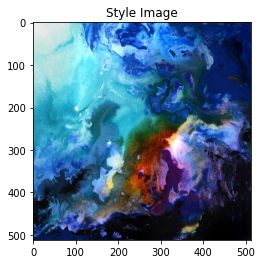

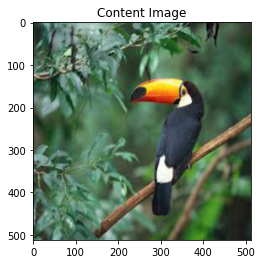

In [93]:
unloader = T.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # Clone the tensor to not do changes on it
    image = image.squeeze(0)      # Remove the fake batch dimension
    image = unloader(image)       # Convert in to PIL Image
    plt.imshow(image)             # Show image
    if title is not None:
        plt.title(title)          # Adding title
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


# **Content Loss Function**


In [94]:

class ContentLoss (nn.Module) :
  def __init__(self,target,):
    super(ContentLoss, self).__init__() #???
    self.target = target.detach() ## # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        
  def forward(self, input):
     #print("ContentLoss" ,input)
     self.loss = F.mse_loss(input,self.target)
     return input

# **Style Loss and Gram Matrix Function**

In [95]:
def gram_matrix(input):
  b,c,h,w = input.size()
  features = input.view(b*c,h*w)
  gram = torch.mm(features, features.t()) # compute the gram product
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
  #print("Gram " , gram)
  return gram.div(b*c*h*w)



In [96]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        #print("StyleLoss" ,input)
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


## **Transfer Learning from VGG Model**

In [97]:
vgg = models.vgg19(pretrained=True).to(device) #We are using a VGG pretrained NN model to accompolish neural style transfer
vgg = vgg.features #To ignore classifier part and use only features part ie. ignoring fully connected networks
vgg.eval() # Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# **Normalisation Module**

In [98]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


# **Model Creation and calculating Losses**

In [99]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn, normalization_mean,normalization_std,style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    
    # list for storing all the losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization) #.to(device)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False) #inplace= True is not working
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses




# **Initialising Input Image and Optimiser**

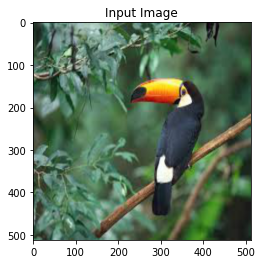

In [100]:
input_img = content_img.clone() #Intitialize input_image
# input_img = torch.randn(content_img.data.size(), device=device)
plt.figure()
imshow(input_img, title='Input Image')

In [101]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer


# **Training the Model**

In [102]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True) #Only input parameters are optimized. so need update
    model.requires_grad_(False) #Model values no need to update. So it is freezed

    optimizer = get_input_optimizer(input_img) #Intiating optimizer

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1) # Keep values in between 0 and 1

            optimizer.zero_grad() #Initialising Optimizer
            model(input_img) # forward propagation
            
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight # beta * total style loss
            content_score *= content_weight # alpha * total content loss

            loss = style_score + content_score #loss function of Neural Image Transfer
            loss.backward() #Backward Propagation

            run[0] += 1
            if run[0] % 50 == 0: #For every 50 iterations
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure) #Gradient decent

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


# **Output New Image**

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


run [50]:
Style Loss : 64.675797 Content Loss: 12.471569

run [100]:
Style Loss : 30.522762 Content Loss: 11.416376

run [150]:
Style Loss : 15.098166 Content Loss: 10.496336

run [200]:
Style Loss : 8.366238 Content Loss: 9.677486

run [250]:
Style Loss : 5.472747 Content Loss: 9.053496

run [300]:
Style Loss : 3.209603 Content Loss: 8.508193



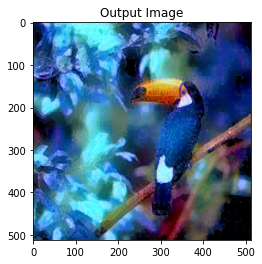

In [103]:
output = run_style_transfer(vgg, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
